In [8]:
%load_ext autoreload
%autoreload 2

import dolfin
import numpy
import sympy
from numpy import linspace
from sympy import lambdify
import scipy.optimize
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

import dolfin_mech     as dmech
import matplotlib.pyplot as plt
import micro_poro_structure_generator as gen
from shapely.geometry import LineString

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Experimental data

In [9]:
smith_gamma_0_inf = numpy.array([
[0.10261460510291531, 10.12867762052346],
[1.0670404781958325, 14.37579169470247],
[1.8163827631860017, 17.871672403295065],
[1.9748719391855454, 19.573866563700566],
[2.1594615644511066, 22.10912106780112],
[2.5164854274353257, 27.42241317661467],
[2.9066567368768337, 34.04958685994136],
[3.3937484592561367, 43.15381056445911],
[3.9145957698017324, 52.5539186331707],
[4.541473207864893, 60.481952639401214],
[5.217917918528443, 68.62351762513866],
[6.241172193676007, 77.1946779015478],
[7.261758091937126, 83.31499516204023],
[8.569970196446437, 88.40221757910093],
[9.93786458361406, 92.1302691779124],
[11.647661204005693, 95.2594309371248],
[13.021679205851322, 96.96864019630578],
[14.650664963066118, 98.82977258733175],
[16.227410106371963, 100.22737839699602]])

p_smith_gamma_0_inf = smith_gamma_0_inf[:, 0]
v_smith_gamma_0_inf = smith_gamma_0_inf[:, 1]



smith_gamma_0_def = numpy.array([
[0.005402644675070236, 9.624888713050963],
[0.1668047591213219, 13.336914018852813],
[0.4784246543693627, 17.576913749523595],
[0.7895795886163685, 22.629626469396946],
[1.049528165662428, 26.98978789511438],
[1.4526998927990538, 32.2156737299415],
[1.807379219882079, 37.46576576043189],
[2.0644723299109122, 42.66182849231477],
[2.3007533812195033, 46.81773063897312],
[2.509263120564099, 50.627115670978604],
[2.7535495873687714, 53.840855918968124],
[3.033910963145054, 58.58295961002058],
[3.3518634250702353, 62.883333664190346],
[3.6492919019388586, 66.62339892776788],
[3.9266765165237323, 69.96982003584168],
[4.321256572989058, 74.121866131073],
[4.807696750702351, 77.78184588726738],
[5.332289000120139, 81.33215478582349],
[6.19081927283565, 85.6636911592568],
[7.169511640775174, 89.30143732413063],
[8.129095122356942, 92.16244173869191],
[9.204640888381636, 94.35632139473529],
[10.399191401051679, 96.39406440195621],
[11.51269213574782, 97.66598370813628],
[12.540963497384666, 98.63105344989252],
[13.656157296595447, 99.30917055539747],
[14.80094434734493, 99.84170685998932],
[16.163451913791032, 100.36715330509323]])

p_smith_gamma_0_def = smith_gamma_0_def[:, 0]
v_smith_gamma_0_def = smith_gamma_0_def[:, 1]



exp_gamma_inflation = numpy.array([
[0.06730815882374686, 9.704082647849843],
[1.9322465182796098, 18.75700665185124],
[3.4904268573026025, 25.24833117463643],
[5.0286694664442555, 31.078643783434696],
[6.485063777631968, 36.02635154219419],
[8.137474528223422, 40.85147550038641],
[9.557268322351398, 44.93923178251944],
[10.429459351434275, 48.12334953139618],
[11.13903532432907, 50.721496058796426],
[11.582845653740943, 53.03754902052973],
[12.014764100158954, 56.587605306853625],
[12.381906403639288, 59.541154955663416],
[12.738693216998744, 63.12519130210577],
[13.224845321048353, 67.58970758392769],
[13.71729461430763, 72.15341503063678],
[14.467392949227415, 77.39116992549216],
[15.062808361558297, 80.80264982801819],
[15.7830582217812, 83.76429049803036],
[16.604808563137663, 86.56123913729672],
[17.30965659020128, 88.45492630421222],
[18.262457705876646, 90.70552669360191],
[19.188369419312806, 92.41092859026006],
[20.0090963410746, 93.80091253847083],
[21.134686061797648, 95.50390718915142],
[22.37148737847479, 97.0422116665291],
[23.392364849410395, 98.10527452251237],
[24.66582227631044, 99.1742013256802],
[25.503449519675073, 99.89714224285996],
[26.342977038435237, 100.47381510525955]])

p_exp_gamma_inflation = exp_gamma_inflation[:, 0]
v_exp_gamma_inflation = exp_gamma_inflation[:, 1]

exp_gamma_deflation = numpy.array([
[0.033315466508945735, 10.125150090091784],
[0.3325077628271477, 15.469867690860674],
[0.6191410581934792, 20.2188364908121],
[0.9880522350473163, 25.69086322684497],
[1.41976347058443, 30.849494769731063],
[1.903019676225418, 36.29383074725043],
[2.387852706130785, 40.9955684895495],
[2.8946399815632855, 45.92731709905034],
[3.389100736544433, 50.388452834823525],
[3.8509485204421114, 54.5232692898636],
[4.435283204568979, 58.93423177845629],
[4.978297006690818, 63.01316892177646],
[5.6483816180411806, 66.71826968050705],
[6.308889043555006, 70.19024649776242],
[7.141245044266598, 73.81700403053497],
[8.12620933179617, 77.12116088322801],
[9.284250298037113, 79.99941722729517],
[10.286397926909286, 81.87430521478251],
[11.52414432736027, 83.52747024521612],
[12.420447627485954, 84.82535660291342],
[13.238940714873207, 86.536784044287],
[14.338735207886664, 88.75594535542344],
[15.472133241072749, 90.83806081569836],
[16.52893905718616, 92.9106327344357],
[17.75050784715548, 94.83745482495748],
[18.961812117634558, 96.40332561217544],
[20.212168058276653, 97.9201803391296],
[21.564067438405665, 98.71853529483946],
[23.081649606544804, 99.45258743535082],
[24.763893670061364, 100.17813063001095],
[26.29242769134445, 100.41890352128218]])

p_exp_gamma_deflation = exp_gamma_deflation[:, 0]
v_exp_gamma_deflation = exp_gamma_deflation[:, 1]


## Defining geometry

In [17]:
seeds_filename = "Geometries/Hexagon/ch4.dat"
mesh_filebasename = "Geometries/Hexagon/ch4-mesh"

domain_y = 0.1 * 0.8
domain_x = domain_y * numpy.sqrt(3)/1.5/2
thickness = 0.012 * 0.8

gen.generate_seeds_semi_regular(
    DoI = 0.,
    row = 1,
    domain_y = domain_y,
    seeds_filename = seeds_filename)
gen.generate_mesh_2D_rectangle_w_voronoi_inclusions(
    mesh_filename = mesh_filebasename,
    seeds_filename = seeds_filename,
    h = thickness,
    lcar = thickness/5,
    domain_x = domain_x,
    domain_y = domain_y,
    shift_y = 0.,
    remove_seeds = True)

mesh = dolfin.Mesh()
dolfin.XDMFFile(mesh_filebasename+".xdmf").read(mesh)
dV = dolfin.Measure("dx",domain=mesh)

coord = mesh.coordinates()
xmax = max(coord[:,0]); xmin = min(coord[:,0])
ymax = max(coord[:,1]); ymin = min(coord[:,1])

V = (xmax - xmin)*(ymax - ymin)
VS0 = dolfin.assemble(dolfin.Constant(1) * dV)
Vf0 = V - VS0

[[0.02309401 0.02      ]
 [0.         0.06      ]
 [0.06928203 0.02      ]
 [0.04618802 0.06      ]]
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 122 (Line)
Info    : [ 10%] Meshing curve 123 (Line)
Info    : [ 10%] Meshing curve 124 (Line)
Info    : [ 20%] Meshing curve 152 (Line)
Info    : [ 20%] Meshing curve 153 (Line)
Info    : [ 20%] Meshing curve 154 (Line)
Info    : [ 30%] Meshing curve 155 (Line)
Info    : [ 30%] Meshing curve 156 (Line)
Info    : [ 30%] Meshing curve 157 (Line)
Info    : [ 40%] Meshing curve 158 (Line)
Info    : [ 40%] Meshing curve 159 (Line)
Info    : [ 40%] Meshing curve 160 (Line)
Info    : [ 50%] Meshing curve 161 (Line)
Info    : [ 50%] Meshing curve 162 (Line)
Info    : [ 50%] Meshing curve 163 (Line)
Info    : [ 60%] Meshing curve 164 (Line)
Info    : [ 60%] Meshing curve 165 (Line)
Info    : [ 70%] Meshing curve 166 (Line)
Info    : [ 70%] Meshing curve 

In [11]:
mesh = dolfin.Mesh()
dolfin.XDMFFile(mesh_filebasename+".xdmf").read(mesh)
dV = dolfin.Measure("dx",domain=mesh)

coord = mesh.coordinates()
xmax = max(coord[:,0]); xmin = min(coord[:,0])
ymax = max(coord[:,1]); ymin = min(coord[:,1])

V = (xmax - xmin)*(ymax - ymin)
VS0 = dolfin.assemble(dolfin.Constant(1) * dV)
Vf0 = V - VS0

## Loading 

In [12]:
qois_filename = "Fig5-qois.dat"
res_basename = "Fig5"

load_params = {}
load_params["pf"] = 4
load_params["sigma_bar_00"] = 0.0
load_params["sigma_bar_11"] = 0.0
load_params["sigma_bar_01"] = 0.0
load_params["sigma_bar_10"] = 0.0

In [13]:
params_id_simth = [0.09434801341294823, 0.016887557819879336, 0.6194667445820958, 3.166746717075454]

In [14]:

params = params_id_simth
mat_params = {"model":"exponential", "parameters":{"beta1":params[0], "beta2":params[1], "beta3":params[2], "alpha":params[3]}}

load_params = {}
load_params["pf"] = 3
load_params["sigma_bar_00"] = 0.0
load_params["sigma_bar_11"] = 0.0
load_params["sigma_bar_01"] = 0.0
load_params["sigma_bar_10"] = 0.0

phi = dmech.run_HollowBox_MicroPoroHyperelasticity(
    dim=2,
    mesh=mesh,
    mat_params=mat_params,
    load_params=load_params,
    step_params={"Deltat":1., "dt_ini":0.1, "dt_min":0.005, "dt_max":0.1},
    res_basename=res_basename,
    write_qois_limited_precision=False,
    verbose=1
)

qois_vals = numpy.loadtxt(qois_filename)
qois_name_list = open(qois_filename).readline().split()
pf_lst = qois_vals[:, qois_name_list.index("p_f") - 1]*10.20
vf_lst = qois_vals[:, qois_name_list.index("vf") - 1]

for i in range(1, len(vf_lst)):
    slope = (vf_lst[i] - vf_lst[i - 1])/(pf_lst[i] - pf_lst[i - 1])
    if slope < 0.1 * Vf0:
        break

vf_asym = vf_lst[i]
vf_lst = [vf_/vf_asym *100 for vf_ in vf_lst]
S_lst = qois_vals[:, qois_name_list.index("S_area") - 1]
S_hat_gamma_0_lst = [S/S_lst[0] for S in S_lst]

vf_gamma_0_lst = vf_lst
pf_gamma_0_lst = pf_lst

In [18]:
load_params = {}
load_params["pf_lst"] = [0.1, 3]
load_params["sigma_bar_00_lst"] = [0.0, 0.0]
load_params["sigma_bar_11_lst"] = [0.0, 0.0]
load_params["sigma_bar_01_lst"] = [0.0, 0.0]
load_params["sigma_bar_10_lst"] = [0.0, 0.0]
load_params["gamma_lst"] = [0.03, 0.03]
load_params["tension_params"] = {"surface_dependancy":1, "d1":1.0130287663205635, "d2":1.6742366271475184, "d3":-10.288589574038403}

step_params = {}
step_params["n_steps"] = 2
step_params["Deltat"] = 1.
step_params["dt_ini"] = 0.01
step_params["dt_min"] = 0.001
step_params["dt_max"] = 0.005

phi = dmech.run_HollowBox_MicroPoroHyperelasticity(
    dim=2,
    mesh=mesh,
    mat_params=mat_params,
    load_params=load_params,
    step_params=step_params,
    res_basename=res_basename,
    write_qois_limited_precision=False,
    verbose=1
)

qois_vals = numpy.loadtxt(qois_filename)
qois_name_list = open(qois_filename).readline().split()
pf_lst = qois_vals[:, qois_name_list.index("p_f") - 1]*10.20
vf_lst = qois_vals[:, qois_name_list.index("vf") - 1]

vf_lst = [vf_/vf_asym *100 for vf_ in vf_lst]

vf_lst_inf = vf_lst
pf_lst_inf = pf_lst

In [19]:
load_params = {}
load_params["pf_lst"] = [0.1, 3]
load_params["sigma_bar_00_lst"] = [0.0, 0.0]
load_params["sigma_bar_11_lst"] = [0.0, 0.0]
load_params["sigma_bar_01_lst"] = [0.0, 0.0]
load_params["sigma_bar_10_lst"] = [0.0, 0.0]
load_params["gamma_lst"] = [0.03, 0.03]
load_params["tension_params"] = {"surface_dependancy":1, "d1":1.030747711797792, "d2":2.1708848554526874, "d3":-14.828598856766776}

step_params = {}
step_params["n_steps"] = 2
step_params["Deltat"] = 1.
step_params["dt_ini"] = 0.1
step_params["dt_min"] = 0.001
step_params["dt_max"] = 0.005

phi = dmech.run_HollowBox_MicroPoroHyperelasticity(
    dim=2,
    mesh=mesh,
    mat_params=mat_params,
    load_params=load_params,
    step_params=step_params,
    res_basename=res_basename,
    write_qois_limited_precision=False,
    verbose=1
)

qois_vals = numpy.loadtxt(qois_filename)
qois_name_list = open(qois_filename).readline().split()
pf_lst = qois_vals[:, qois_name_list.index("p_f") - 1]*10.20
vf_lst = qois_vals[:, qois_name_list.index("vf") - 1]

vf_lst = [vf_/vf_asym *100 for vf_ in vf_lst]

vf_lst_def = vf_lst
pf_lst_def = pf_lst

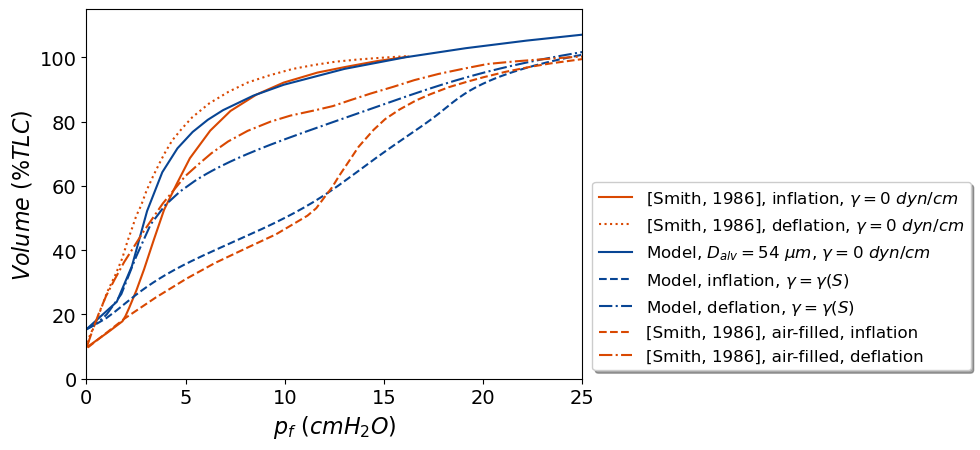

In [ ]:
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=12)
plt.xlabel(r'$p_f~(cm H_2O)$', fontsize=16)
plt.ylabel(r'$Volume~(\% TLC)$', fontsize=16)

plt.plot(p_smith_gamma_0_inf, v_smith_gamma_0_inf, '#D94801', label='[Smith, 1986], inflation, $\gamma = 0~dyn/cm$')
plt.plot(p_smith_gamma_0_def, v_smith_gamma_0_def, '#D94801', linestyle='dotted', label='[Smith, 1986], deflation, $\gamma = 0~dyn/cm$')


plt.plot(pf_gamma_0_lst, vf_gamma_0_lst, '#084594', label='Model, $\gamma = 0~dyn/cm$')
plt.plot(pf_lst_inf, vf_lst_inf, '#084594', linestyle='dashed', label='Model, inflation, $\gamma = \gamma(S)$')
plt.plot(pf_lst_def, vf_lst_def, '#084594', linestyle='dashdot', label='Model, deflation, $\gamma = \gamma(S)$')


plt.plot(p_exp_gamma_inflation, v_exp_gamma_inflation, '#D94801', linestyle='dashed', label='[Smith, 1986], air-filled, inflation')
plt.plot(p_exp_gamma_deflation, v_exp_gamma_deflation, '#D94801', linestyle='dashdot', label='[Smith, 1986], air-filled, deflation')

plt.xlim(0, 25)
plt.ylim(0, 115)
plt.legend(loc = 'lower right', fontsize=12, bbox_to_anchor=(1.8, 0.), shadow=True)
plt.savefig('Figures/surface_dependent_surface_tension.pdf',bbox_inches='tight')

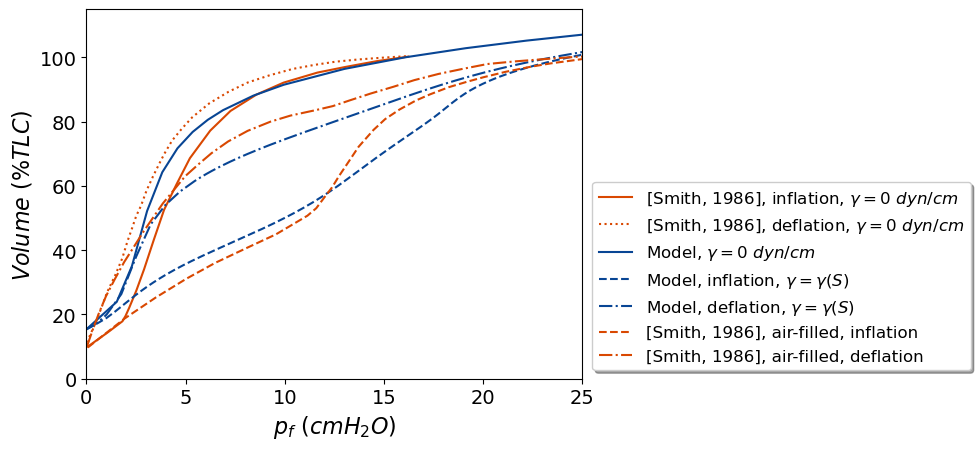

In [20]:
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=12)
plt.xlabel(r'$p_f~(cm H_2O)$', fontsize=16)
plt.ylabel(r'$Volume~(\% TLC)$', fontsize=16)

plt.plot(p_smith_gamma_0_inf, v_smith_gamma_0_inf, '#D94801', label='[Smith, 1986], inflation, $\gamma = 0~dyn/cm$')
plt.plot(p_smith_gamma_0_def, v_smith_gamma_0_def, '#D94801', linestyle='dotted', label='[Smith, 1986], deflation, $\gamma = 0~dyn/cm$')


plt.plot(pf_gamma_0_lst, vf_gamma_0_lst, '#084594', label='Model, $\gamma = 0~dyn/cm$')
plt.plot(pf_lst_inf, vf_lst_inf, '#084594', linestyle='dashed', label='Model, inflation, $\gamma = \gamma(S)$')
plt.plot(pf_lst_def, vf_lst_def, '#084594', linestyle='dashdot', label='Model, deflation, $\gamma = \gamma(S)$')


plt.plot(p_exp_gamma_inflation, v_exp_gamma_inflation, '#D94801', linestyle='dashed', label='[Smith, 1986], air-filled, inflation')
plt.plot(p_exp_gamma_deflation, v_exp_gamma_deflation, '#D94801', linestyle='dashdot', label='[Smith, 1986], air-filled, deflation')

plt.xlim(0, 25)
plt.ylim(0, 115)
plt.legend(loc = 'lower right', fontsize=12, bbox_to_anchor=(1.8, 0.), shadow=True)
plt.savefig('Figures/surface_dependent_surface_tensio.pdf',bbox_inches='tight')